In [1]:
import pandas as pd
import numpy as np
import torch
from utilities import *
from linear_atomic import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchattacks
import os
torch.set_default_dtype(torch.float32)

# https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17
data = pd.read_csv("data/star_classification.csv")#, nrows = 2000)

def one_hot(array):
    unique, inverse = np.unique(array, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot

In [2]:
data

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [3]:
data["class"].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [4]:
xcols = ["alpha", "delta", "u", "g", "r", "i", "z", "redshift"]
ycol = "class"
classes = len(data[ycol].unique())

X_train, X_test, y_train, y_test = train_test_split(data[xcols], data[ycol])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_train = torch.tensor(scaler.transform(X_train.values)).to(torch.float32)
y_train = torch.tensor(one_hot(y_train.values))
X_test = torch.tensor(scaler.transform(X_test.values)).to(torch.float32)
y_test = torch.tensor(one_hot(y_test.values))

# Creating our dataset class
class BuildData(torch.utils.data.Dataset):    
    # Constructor
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = len(self.x)        
    # Getting the data
    def __getitem__(self, index):    
        return self.x[index], self.y[index]    
    # Getting length of the data
    def __len__(self):
        return self.len

train_dataset = BuildData(X_train, y_train)
test_dataset = BuildData(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = 200)#, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 1)

In [5]:
class Classifier(torch.nn.Module):
    def __init__(self, atomics=False):
        super(Classifier, self).__init__()
        if atomics:
            self.layer0 = AtomicLinear(len(xcols), 5*len(xcols))
            self.layer1 = AtomicLinear(5*len(xcols), 5*len(xcols))
            self.layer2 = AtomicLinear(5*len(xcols), classes)

        else:
            self.layer0 = torch.nn.Linear(len(xcols),5*len(xcols))
            self.layer1 = torch.nn.Linear(5*len(xcols),5*len(xcols))
            self.layer2 = torch.nn.Linear(5*len(xcols),classes)
        
        self.norm1 = torch.nn.BatchNorm1d(5*len(xcols))
        self.norm2 = torch.nn.BatchNorm1d(5*len(xcols))
        self.activation = torch.nn.ReLU()
        self.probs = torch.nn.Softmax()
        assign_fixed_params(self)

    def forward(self,x):
        y0 = self.norm1(self.activation(self.layer0(x)))
        y1 = self.norm2(self.activation(self.layer1(y0)))
        y2 = self.layer2(y1)
        return y2
        #return self.probs(y1)

class ClassifierTest(torch.nn.Module):
    def __init__(self, atomics=False):
        super(ClassifierTest, self).__init__()
        self.layer0 = AtomicLinearTest(len(xcols), 5*len(xcols))
        self.layer1 = AtomicLinearTest(5*len(xcols), 5*len(xcols))
        self.layer2 = AtomicLinearTest(5*len(xcols), classes)
        
        self.norm1 = torch.nn.BatchNorm1d(5*len(xcols))
        self.norm2 = torch.nn.BatchNorm1d(5*len(xcols))
        self.activation = torch.nn.ReLU()
        self.probs = torch.nn.Softmax()
        assign_fixed_params(self)

    def forward(self,x):
        y0 = self.norm1(self.activation(self.layer0(x)))
        y1 = self.norm2(self.activation(self.layer1(y0)))
        y2 = self.layer2(y1)
        return y2
        #return self.probs(y1)

In [6]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    for x,y in dataloader:
        optimizer.zero_grad()
        y_logits = model(x)
        _, classtype = torch.max(y,1)
        loss = criterion(y_logits, classtype)
        loss.backward()
        optimizer.step()
    #print(loss)
    #for param in model.parameters():
    #    print(param.grad)
    return loss

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            prediction_prob = model(data)
            prediction = torch.argmax(prediction_prob, dim=1)
            target = torch.argmax(target, dim=1)
            for i in range(len(prediction)):
                if prediction[i]==target[i]:
                    correct+=1
                total+=1
    return correct, total

In [7]:
def train_new_model(atomics: bool, epochs: int):
    model = Classifier(atomics=atomics)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    loss_history = []
    accuracy_history = []
    for epoch in range(epochs):
        loss = train(model, train_loader, criterion, optimizer).item()
        correct,total = test(model, test_loader)
        scheduler.step()
        #print(loss, correct ,total)
        loss_history.append(loss)
        accuracy_history.append(100.0*(float(correct)/float(total)))

    return model, loss_history, accuracy_history
    

In [8]:
# note the numpy lists were the wrong shapes...

#def save_to_files(models, losses, accuracies):
#    for i,model in enumerate(models):
#        torch.save(model.state_dict(), f"atomic_models/model_{i}.pth")

#    np.save("atomic_models/losses.npy", losses)
#    np.save("atomic_models/accuracies.npy", accuracies)

#num_epochs = 25
#num_models = 50
#models=[]
#losses=np.array([])
#accuracies=np.array([])
#for i in range(num_models):
#    model, loss, accuracy = train_new_model(True, num_epochs)
#    models.append(model)
#    losses=np.append(losses,loss)
#    accuracies=np.append(accuracies,accuracy)

#    save_to_files(models,losses,accuracies)

In [21]:
#torch.save(model.state_dict(), f"atomic_models/model.pth")

In [11]:
num_epochs = 25
num_models = 50
losses = np.load("atomic_models/losses.npy")
accuracies = np.load("atomic_models/accuracies.npy")
models=[]
for i in range(num_models):
    model = Classifier(atomics=True)
    model.load_state_dict(torch.load(f"atomic_models/model_{i}.pth"))
    model.eval()
    models.append(model)

In [20]:
test(models[0], test_loader)

(24178, 25000)

In [21]:
losses = np.reshape(losses, (num_models,num_epochs))
accuracies = np.reshape(accuracies, (num_models,num_epochs))

In [22]:
accuracies.shape

(50, 25)

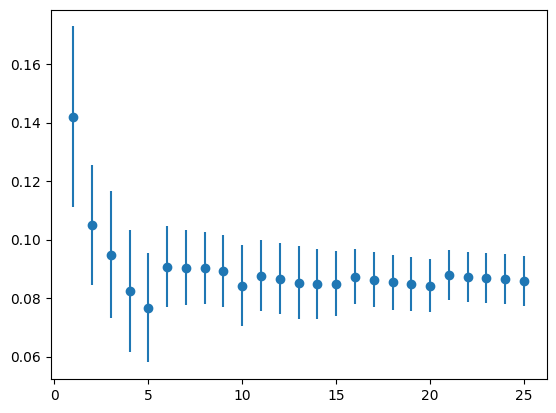

In [23]:
plt.errorbar(list(range(1,num_epochs+1)), np.mean(losses,axis=0), np.std(losses,axis=0),linestyle="None",marker="o")
plt.show()

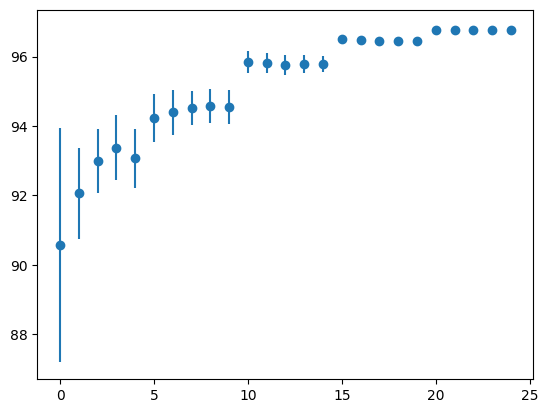

In [24]:
plt.errorbar(list(range(num_epochs)), np.mean(accuracies,axis=0), np.std(accuracies,axis=0),linestyle="None",marker="o")
plt.show()

In [25]:
accuracies[:,-1]

array([96.784, 96.792, 96.76 , 96.748, 96.768, 96.384, 96.796, 96.78 ,
       96.744, 96.8  , 96.792, 96.804, 96.368, 96.788, 96.772, 96.812,
       96.764, 96.784, 96.764, 96.744, 96.788, 96.764, 96.808, 96.804,
       96.772, 96.784, 96.776, 96.788, 96.808, 96.772, 96.784, 96.608,
       96.784, 96.756, 96.78 , 96.768, 96.796, 96.768, 96.776, 96.764,
       96.764, 96.772, 96.804, 96.74 , 96.808, 96.772, 96.752, 96.752,
       96.868, 96.792])

## Attack the networks

* Pick an attack like gradient
* epsilon sized attack
* P(missclassificatoin) vs R^Features radius


Find x1 classed as GALAXY
Find x2 classed as STAR

find where it switches in R^Features up to some ( $\delta$ FP precision...), try raidus $r$ for classification change.



https://adversarial-ml-tutorial.org/linear_models/

can try with my linear layer too see what happens!


In [8]:
# FGSM attack code
def fgsm_input(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

def fgsm_attack(model, data_loader, criterion, epsilon):
    correct = 0
    model.eval()
    for x,y in data_loader:
        x.requires_grad = True
        output = model(x)
        
        init_pred = output.max(1, keepdim=True)[1]
        #print(init_pred)
    
        if init_pred.item() != y.max(1,keepdim=True)[1].item():
            continue

        _, classtype = torch.max(y,1)
        loss = criterion(output, classtype)
        model.zero_grad()
        loss.backward()
    
        # TODO: denorm
        perturbed_data = fgsm_input(x, epsilon, x.grad.data)
        # TODO: normalize

        output = model(perturbed_data)
        prediction = torch.argmax(output, dim=1)
        target = torch.argmax(y, dim=1)
        if prediction.item()==target.item():
            correct+=1

    return correct

In [27]:
#fgsm_attack(models[0], test_loader, torch.nn.CrossEntropyLoss(), 0.0)

In [28]:
criterion = torch.nn.CrossEntropyLoss()

def run_for_epsilon(epsilon):
    eps_str = f"{epsilon:0.5f}".replace(".","p")
    print(f"running for e={eps_str}")
    model_correct = np.array([])
    for model in models:
        correct = fgsm_attack(model, test_loader, torch.nn.CrossEntropyLoss(), epsilon)
        model_correct = np.append(model_correct,correct)
    np.save(f"atomic_models/fgsm_attacks_eps{eps_str}.npy", model_correct)

In [54]:
run_for_epsilon(0.00001)

running for e=0p00001


In [59]:
eps_files = [filename for filename in os.listdir('./atomic_models') if filename.startswith('fgsm')]
eps = []
means = []
errs = []
for file in eps_files:
    data = np.load(f'./atomic_models/{file}')
    means.append(np.mean(data))
    errs.append(np.std(data))
    eps_value = float(file.split('eps')[1].split('.npy')[0].replace('p','.'))
    eps.append(eps_value)

print(means, errs)

[22403.64, 24170.46, 24175.64, 24115.36, 23676.92] [338.8374690024703, 21.85791389863177, 21.248774082285312, 30.63446425188467, 115.28622467580419]


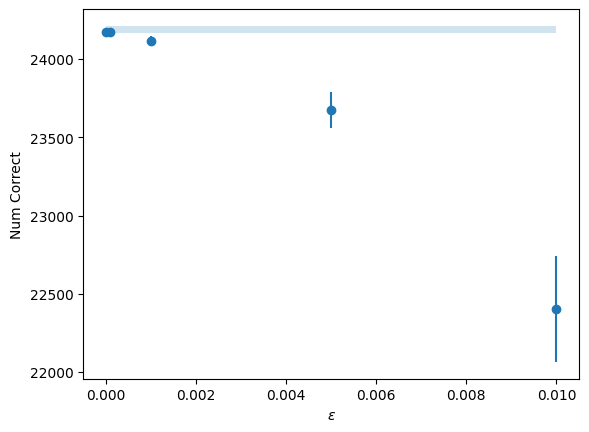

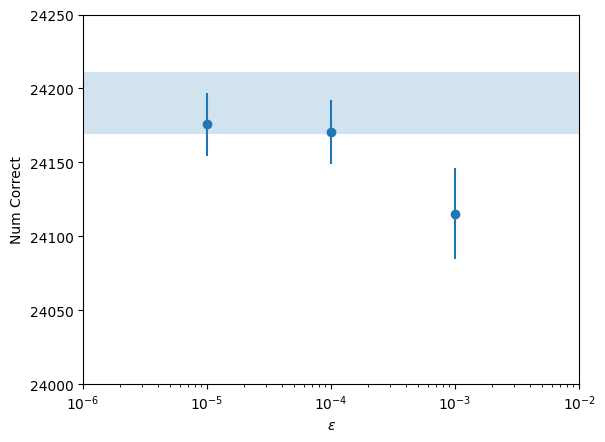

In [75]:
correct_mean = np.mean(accuracies[:,-1]*len(test_loader)/100.)
correct_err = np.std(accuracies[:,-1]*len(test_loader)/100.)
plt.errorbar(eps, means, errs,linestyle="None",marker="o")
plt.fill_between([0,1e-2], correct_mean-correct_err, correct_mean+correct_err, alpha=0.2)
plt.xlabel(r'$\epsilon$')
plt.ylabel('Num Correct')
plt.show()
plt.errorbar(eps, means, errs,linestyle="None",marker="o")
plt.fill_between([0,1], correct_mean-correct_err, correct_mean+correct_err, alpha=0.2)
plt.xlabel(r'$\epsilon$')
plt.ylabel('Num Correct')
plt.xlim(1e-6,1e-2)
plt.xscale('log')
plt.ylim(24000,24250)
plt.show()

In [52]:
test(models[0], test_loader)

(24180, 25000)

In [38]:
model, loss, accuracy = train_new_model(False, 25)

/home/cculver/anaconda3/envs/generalml/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [41]:
accuracy

[94.704,
 93.604,
 95.19999999999999,
 95.86,
 95.04,
 95.536,
 94.58,
 94.38,
 93.96,
 96.344,
 96.492,
 96.54,
 96.572,
 96.596,
 96.612,
 96.624,
 96.64399999999999,
 96.64399999999999,
 96.64,
 96.652,
 96.66799999999999,
 96.66799999999999,
 96.66799999999999,
 96.67999999999999,
 96.684]

In [43]:
len(test_loader)*96.684/100

24171.0

In [42]:
fgsm_attack(model, test_loader, torch.nn.CrossEntropyLoss(), 0.005)

24094

* Definitely add Deterministic trianed model for each epsilon

* Can mix ND/D Training and ND/D inference

* Fixed vs variable Adversarial Inputs if adversarial attack depends on the model.

### ND Models but D inference

In [29]:
models=[]
num_models=50
for i in range(num_models):
    model = Classifier(atomics=False)
    model.load_state_dict(torch.load(f"atomic_models/model_{i}.pth"))
    model.eval()
    models.append(model)

In [31]:
criterion = torch.nn.CrossEntropyLoss()

def run_for_epsilon(epsilon):
    eps_str = f"{epsilon:0.5f}".replace(".","p")
    print(f"running for e={eps_str}")
    model_correct = np.array([])
    for model in models:
        correct = fgsm_attack(model, test_loader, torch.nn.CrossEntropyLoss(), epsilon)
        model_correct = np.append(model_correct,correct)
    np.save(f"atomic_models/fgsm_attacks_eps{eps_str}_detinf.npy", model_correct)

In [33]:
for eps in [0.00001,0.00005,0.0001,0.0005,0.001]:
    run_for_epsilon(eps)

running for e=0p00001
running for e=0p00005
running for e=0p00010
running for e=0p00050
running for e=0p00100


## Runs for D/ND Training & Inference

In [10]:
# FGSM attack code
def fgsm_input(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

def fgsm_attack(model, data_loader, criterion, epsilon):
    correct = 0
    model.eval()
    for x,y in data_loader:
        x.requires_grad = True
        output = model(x)
        
        init_pred = output.max(1, keepdim=True)[1]
        #print(init_pred)
    
        if init_pred.item() != y.max(1,keepdim=True)[1].item():
            continue

        _, classtype = torch.max(y,1)
        loss = criterion(output, classtype)
        model.zero_grad()
        # should check that this is deterministic - 
        loss.backward()
    
        # TODO: denorm
        perturbed_data = fgsm_input(x, epsilon, x.grad.data)
        # TODO: normalize

        output = model(perturbed_data)
        prediction = torch.argmax(output, dim=1)
        target = torch.argmax(y, dim=1)
        if prediction.item()==target.item():
            correct+=1

    return correct

In [11]:
def run_fgsm(epsilon, deterministic_training=True, deterministic_inference=True):
    models = []
    if deterministic_training:
        if deterministic_inference:
            model = Classifier(atomics=deterministic_inference)
            model.load_state_dict(torch.load(f"atomic_models/model.pth"))
            model.eval()
            models.append(model)
        else:
            # D training - ND inference
            # 50 models - same weights - atomic operations
            # create 50 attacks (from atomic operations)
            # do inference on each attacked input
            # maybe break apart also
            for i in range(num_models):
                
                model = Classifier(atomics=deterministic_inference)
                model.load_state_dict(torch.load(f"atomic_models/model.pth"))
                model.eval()
                models.append(model)
    else:
        for i in range(num_models):
            model = Classifier(atomics=deterministic_inference)
            model.load_state_dict(torch.load(f"atomic_models/model_{i}.pth"))
            model.eval()
            models.append(model)

    num_correct = []

    for model in models:
        num_correct.append(fgsm_attack(model, test_loader, torch.nn.CrossEntropyLoss(), epsilon))

    return np.array(num_correct)            

In [159]:
import pandas as pd

data = pd.read_csv('atomic_models/fgsm.csv')
data['num_correct'] = data['num_correct'].apply(lambda x: np.array(pd.eval(x.replace('\n','').replace(' ', ','))))
num_models=50
#data = pd.DataFrame(columns = ['epsilon', 'deterministic_training', 'deterministic_inference'])
completed = set(tuple(row) for row in data[['epsilon', 'deterministic_training', 'deterministic_inference']].to_records(index=False))
#for epsilon in [1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6,1e-7,5e-7,1e-8]:
for epsilon in [0,2e-3,3e-3,7e-3,2e-4,3e-4,7e-4]:
#print(epsilon)
    for train_mode in [False,True]:
        for infer_mode in [False,True]:
            params = {'epsilon': epsilon, 'deterministic_training': train_mode, 'deterministic_inference': infer_mode}
            
            if tuple(params.values()) in completed:
                #print(tuple(params.values()))
                #print("done before")
                continue
            else:
                num_correct = run_fgsm(epsilon, train_mode, infer_mode)

            params['num_correct']=num_correct
            params = pd.DataFrame([params])
            data = pd.concat([data, params], ignore_index=True)
            data.to_csv('atomic_models/fgsm.csv')

In [160]:
dI_dT_filter = (data['deterministic_training'] == True) & (data['deterministic_inference'] == True)
xdd,ydd = data[dI_dT_filter][['epsilon','num_correct']].T.values
ydd = np.array([a[0] for a in ydd])

In [161]:
def get_errplt_data(training,inference):
    fil = (data['deterministic_training'] == training) & (data['deterministic_inference'] == inference)
    xdd, ydd = data[fil][['epsilon','num_correct']].T.values
    ydd = np.array([a for a in ydd])
    #print(xdd, ydd)
    return xdd, np.mean(ydd,axis=1), np.std(ydd,axis=1)

In [162]:
for train,inf in [[True,False],[False,True],[False,False]]:
    print(get_errplt_data(train,inf))

(array([0.0001, 0.0005, 1e-05, 5e-05, 1e-06, 5e-06, 1e-07, 5e-07, 1e-08,
       0.001, 0.005, 0.0, 0.002, 0.003, 0.007, 0.0002, 0.0003, 0.0007],
      dtype=object), array([24244., 24238., 24244., 24244., 24245., 24245., 24245., 24245.,
       24245., 24133., 24045., 24149., 24115., 24095., 23962., 24147.,
       24145., 24137.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]))
(array([0.0001, 0.0005, 1e-05, 5e-05, 1e-06, 5e-06, 1e-07, 5e-07, 1e-08,
       0.001, 0.005, 0.0, 0.002, 0.003, 0.007, 0.0002, 0.0003, 0.0007],
      dtype=object), array([24235.1 , 24220.58, 24238.3 , 24237.04, 24238.5 , 24238.38,
       24238.5 , 24238.5 , 24238.5 , 24167.76, 23913.64, 24194.82,
       24126.34, 24071.74, 23659.38, 24190.66, 24188.28, 24177.42]), array([17.27338994, 17.65456315, 17.54793435, 17.49852565, 17.49771414,
       17.49958857, 17.49771414, 17.49771414, 17.49771414, 18.85371051,
       53.95025857, 17.31206516, 20.63066649, 27.03465184, 99.6493

In [163]:
accuracies = np.load("atomic_models/accuracies.npy")
num_epochs=25
accuracies = np.reshape(accuracies, (num_models,num_epochs))
correct_mean = np.mean(accuracies[:,-1]*len(test_loader)/100.)
correct_err = np.std(accuracies[:,-1]*len(test_loader)/100.)

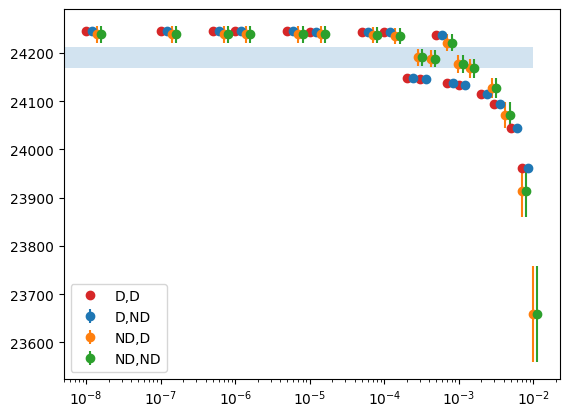

In [164]:
mklabel = lambda t,i: ('D' if t else 'ND') + ',' + ('D' if i else 'ND')
for i, (train,inf) in enumerate([[True,False],[False,True],[False,False]]):
    x,y,err = get_errplt_data(train,inf)
    plt.errorbar(x+(i+1)*0.2*x,y,err,linestyle='None',marker='o', label=mklabel(train,inf))

plt.plot(xdd,ydd,linestyle = 'None', marker='o', label="D,D")
plt.fill_between([0,1e-2], correct_mean-correct_err, correct_mean+correct_err, alpha=0.2)
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()

In [167]:
# ND - 50 models from ND training

# D inference/attack - output(x) is the same, fgsm attack is the same for any number of runs on that model
# ND inference/attack - output(x) varies, fgsm attack varies for each run on model i

# dmodel
# 50 fgsm attacks with ND inference

# [model1, model2]
# for each do 50 fgsm attacks with ND inference
# 2*50 samples 

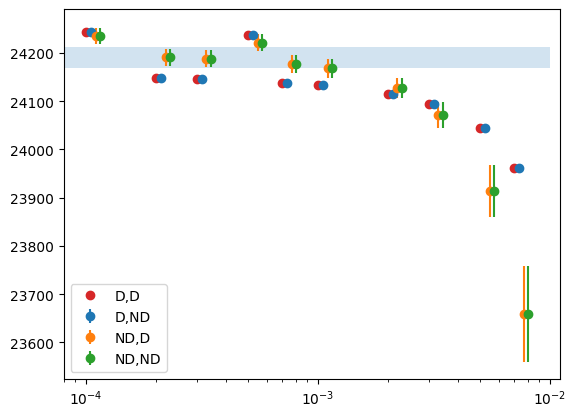

In [165]:
mklabel = lambda t,i: ('D' if t else 'ND') + ',' + ('D' if i else 'ND')
for i, (train,inf) in enumerate([[True,False],[False,True],[False,False]]):
    x,y,err = get_errplt_data(train,inf)
    plt.errorbar(x+(i+1)*0.05*x,y,err,linestyle='None',marker='o', label=mklabel(train,inf))

plt.plot(xdd,ydd,linestyle = 'None', marker='o', label="D,D")
plt.fill_between([0,1e-2], correct_mean-correct_err, correct_mean+correct_err, alpha=0.2)
plt.xscale('log')
plt.xlim(8e-5,1.1e-2)
plt.legend(loc='lower left')
plt.show()

In [166]:
accuracies[:,-1]*len(test_loader)/100

array([24196., 24198., 24190., 24187., 24192., 24096., 24199., 24195.,
       24186., 24200., 24198., 24201., 24092., 24197., 24193., 24203.,
       24191., 24196., 24191., 24186., 24197., 24191., 24202., 24201.,
       24193., 24196., 24194., 24197., 24202., 24193., 24196., 24152.,
       24196., 24189., 24195., 24192., 24199., 24192., 24194., 24191.,
       24191., 24193., 24201., 24185., 24202., 24193., 24188., 24188.,
       24217., 24198.])